In [1]:
import math
import numpy as np
from lib import NesterovsLinearCoupling
# from lib import SinkhornMethod
from lib import Experiments

np.seterr(all="raise")

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
class SinkhornMethod:
    def __init__(self, gamma, n=5, epsilon=0.001, epsilon_prox=0.001, log=False):
        """
        Sinkhorn Method for Transport Problem
        :param gamma: regularizer multiplier
        :param dim: transport vector dimension
        :param epsilon: desired accuracy
        """
        
        # dual func variables for indicator functions
        # self.lambda_ = np.zeros(n)
        self.lambda_ = np.zeros(n).astype(np.float)
        self.my = np.zeros(n)
        
        # constants
        self.gamma = gamma
        self.n = n
        self.epsilon = epsilon
        self.epsilon_prox = epsilon_prox
        
        self.log = log
        if self.log:
            print("–––––––––––––––––––––––––––––")
            print("Algorithm configuration:")
            print("gamma = " + str(gamma))
            print("eps = " + str(epsilon))
            print("eps prox = " + str(self.epsilon_prox))
            print("–––––––––––––––––––––––––––––\n")
    
    def _new_dual_variables(self, C, p, q, xk):
        """
        Calculates Lagrange equation variables
        """
        
        a = np.min(self.gamma + C + self.my.repeat(self.n).reshape((-1, self.n)))
        
        for i in range(self.n):
            try:
                self.lambda_[i] = self.gamma * (-a + np.log(1/p[i] * np.sum([xk[i, j] * np.exp(-(self.gamma + C[i, j] + self.my[j] - a)/self.gamma) for j in range(self.n)])))
            except:
                self.lambda_[i] = -np.inf


            
        a = np.min(self.gamma + C + self.lambda_.repeat(self.n).reshape((-1, self.n)).T)

        for j in range(self.n):
            try:
                self.my[j] = self.gamma * (-a + np.log(1/q[j] * np.sum([xk[i, j] * np.exp(-(self.gamma + C[i, j] + self.lambda_[i] - a)/self.gamma) for i in range(self.n)])))
            except:
                self.my[j] = -np.inf
    
    def _new_x(self, C, p, q, xk):
        x = np.zeros((self.n, self.n))
        
        a = np.min(self.gamma + C + self.lambda_.repeat(self.n).reshape((-1, self.n)) + self.my.repeat(self.n).reshape((-1, self.n)).T)
        
        for i in range(self.n):
            for j in range(self.n):
                try:
                    x[i, j] = xk[i, j] * np.exp(-(self.gamma + C[i, j] + self.lambda_[i] + self.my[j] - a)/self.gamma)
                except:
                    x[i, j] = 0
        return x
    
    def _new_phi(self, C, p, q, xk):
        x_sum = 0
        
        a = np.min(self.gamma + C + self.lambda_.repeat(self.n).reshape((-1, self.n)) + self.my.repeat(self.n).reshape((-1, self.n)).T)
        
        for i in range(self.n):
            for j in range(self.n):
                try:
                    x_sum += xk[i, j] * np.exp(-(C[i,j] + self.lambda_[i] + self.my[j] + self.gamma - a) / self.gamma)
                except:
                    x_sum += 0
                
        return - np.sum(self.lambda_ * p) - np.sum(self.my * q) - self.gamma * x_sum
    
    def _new_f(self, C, x, xk):
        return np.sum(C * x) + self.gamma * np.sum((x + 1e-16) * np.log((x + 1e-16) / xk))
    
    def fit(self, C, p, q, with_prox=True):
        T = 0
        k = 0
        x = 1/self.n**2 * np.ones((self.n, self.n))
        while True:
            xk = x.copy() / np.sum(x)
            
            t = 0
            while True:
                self._new_dual_variables(C, p, q, xk)
                x = self._new_x(C, p, q, xk)
                     
                t += 1  
                T += 1
                
                self.phi = self._new_phi(C, p, q, xk)
                self.f = self._new_f(C, x, xk) 
                    
                c = 1 / (2 * self.n) * (np.sum(self.my) - np.sum(self.lambda_))
                self.lambda_ += c
                self.my -= c
                
                self.epsilon_ = self.epsilon / np.sqrt(np.linalg.norm(self.lambda_, 2) ** 2 + np.linalg.norm(self.my, 2) ** 2)
                if self.log:
                    print("Inner iteration " + str(t) + ":", "metric (one) = " + str(round((((p - x.sum(1))**2).sum() + ((q - x.sum(0))**2).sum())**(1/2), 6)), "> " + str(self.epsilon_), "or metric (two) = " + str(round(self.f - self.phi, 6)), "> " + str(self.epsilon))
                    
                if (((p - x.sum(1))**2).sum() + ((q - x.sum(0))**2).sum())**(1/2) < self.epsilon_ and self.f - self.phi < self.epsilon:
                    if self.log:
                        print("Inner iteration " + str(t) + ":", "metric (one) = " + str(round((((p - x.sum(1))**2).sum() + ((q - x.sum(0))**2).sum())**(1/2), 6)), "< " + str(self.epsilon_), "and metric (two) = " + str(round(self.f - self.phi, 6)), "< " + str(self.epsilon))
                    break
                
            if not with_prox:
                return x, T, k
            
            if self.log:
                print("– Outer iteration " + str(k) + ":", "metric = " + str(round(np.linalg.norm(x - xk, 2), 4)), "> " + str(self.epsilon_prox))
            
            k += 1
            if np.linalg.norm(x - xk, 2) < self.epsilon_prox:
                if self.log:
                    print("– Outer iteration " + str(k) + ":", "metric = " + str(round(np.linalg.norm(x - xk, 2), 4)), "< " + str(self.epsilon_prox))
                return x, T, k

In [7]:
def coupling(C, p, q, gamma=0.1, eps=0.01, nesterovs=False, log=False):
    nlc = NesterovsLinearCoupling(gamma, n=p.shape[0], epsilon=eps, nesterovs=nesterovs, log=log)
    x, iterations_num = nlc.fit(C, p, q)
    return x, iterations_num, 0

def sinkhorn(C, p, q, gamma=0.1, eps=0.01, log=False):
    sm = SinkhornMethod(gamma, n=p.shape[0], epsilon=eps, log=log)
    x, inner_iterations_num, outer_iterations_num = sm.fit(C, p, q, with_prox=False)
    return x, inner_iterations_num, outer_iterations_num

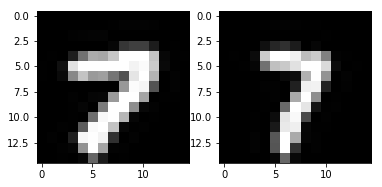

In [8]:
problems = []

for i in range(10, 16, 1):
    (C, p, q) = Experiments.load_data('test_data/1.png', 'test_data/2.png', show=i==15, size=i)
    problems.append((C, p, q))

In [45]:
def B(u, v, C, gamma):
    try:
        K = np.exp(-C/ gamma)
    except:
        K = 0
    return np.matmul(np.matmul(np.diag(np.exp(u)), K), np.diag(np.exp(v)))

In [46]:
def sinkhorn(C, r, c, epsilon, gamma=0.5):  
    u = np.zeros(len(C))
    v = np.zeros(len(C))    
    
    k = 0
    while True:
        if k % 2 == 0:
            u = u + np.log(r) - np.log(B(u, v, C, gamma).sum(1))
            
        else:
            v = v + np.log(c) - np.log(B(u, v, C, gamma).sum(0))
        
        k += 1
        
        if np.abs(B(u, v, C, gamma).sum(1) - r).sum() +\
           np.abs(B(u, v, C, gamma).sum(0) - c).sum() <= epsilon:
            break
            
    return B(u, v, C, gamma), k


In [47]:
c = np.ones((3, 3))
p = np.array([0.2, 0.4, 0.4])
q = np.array([0.4, 0.4, 0.2])

sinkhorn(c, p, q, 0.1, gamma=0.01)

(array([[0.08, 0.08, 0.04],
        [0.16, 0.16, 0.08],
        [0.16, 0.16, 0.08]]), 2)

In [48]:
c, p, q = problems[0]
gammas = np.linspace(0.01, 1, 20)
gammas

array([0.01      , 0.06210526, 0.11421053, 0.16631579, 0.21842105,
       0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
       0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
       0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ])

In [49]:
gamma = gammas[0]
print(gamma)
sinkhorn(c, p, q, 0.1, gamma)

0.01


ValueError: Scalar operands are not allowed, use '*' instead

In [ ]:
s

In [ ]:

plt.plot([sinkhorn(c, p, q, 0.1, gamma)[0] for gamma in gammas])

In [9]:
x, inner_iterations_num, outer_iterations_num = sinkhorn(*problems[0], gamma=0.004, eps=0.1, log=True)

–––––––––––––––––––––––––––––
Algorithm configuration:
gamma = 0.004
eps = 0.1
eps prox = 0.001
–––––––––––––––––––––––––––––



FloatingPointError: invalid value encountered in double_scalars

In [ ]:
gamma_ = 0.1 / (4 * np.log(p.shape[0]))

In [6]:
a = np.array([1]).astype(np.double)
a = -np.inf

In [5]:
x, iterations_num, _ = coupling(*problems[0], gamma=0.004, eps=0.1, nesterovs=False, log=True)

–––––––––––––––––––––––––––––
Algorithm configuration:
gamma = 0.004
eps = 0.1
–––––––––––––––––––––––––––––

iteration 25:   criteria 1 = 0.1048466, criteria 2 = 1.9719516
iteration 50:   criteria 1 = 0.084544, criteria 2 = 1.9636698
iteration 75:   criteria 1 = 0.0822925, criteria 2 = 1.9523442
iteration 100:   criteria 1 = 0.0818733, criteria 2 = 1.9373279
iteration 125:   criteria 1 = 0.0817657, criteria 2 = 1.9181783
iteration 150:   criteria 1 = 0.08173, criteria 2 = 1.8946851
iteration 175:   criteria 1 = 0.0817123, criteria 2 = 1.866934
iteration 200:   criteria 1 = 0.081703, criteria 2 = 1.8351045
iteration 225:   criteria 1 = 0.0816986, criteria 2 = 1.7991397
iteration 250:   criteria 1 = 0.0793265, criteria 2 = 1.7609079
iteration 275:   criteria 1 = 0.0766814, criteria 2 = 1.7395643
iteration 300:   criteria 1 = 0.0661546, criteria 2 = 1.7473903
iteration 325:   criteria 1 = 0.0598647, criteria 2 = 1.7553179
iteration 350:   criteria 1 = 0.0520036, criteria 2 = 1.7701472
it

KeyboardInterrupt: 

In [ ]:
epsilon = 0.01
epsilons, gammas, iterations = Experiments.test([problems[0]], 
                                                config={'eps': (epsilon, epsilon, 1), 
                                                        'gamma': (1, 0.01, 1.5)},
                                                methods=[coupling, sinkhorn])

  4%|▍         | 1/24 [00:00<00:17,  1.33it/s]

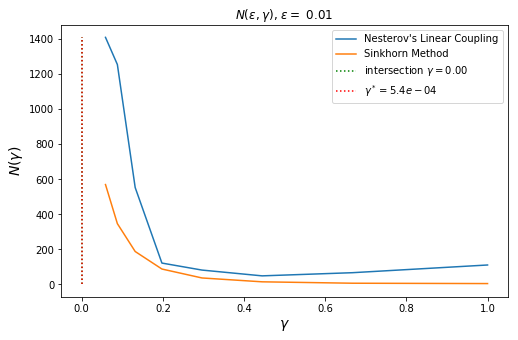

In [16]:
Experiments.plot_algorithm_comparation(gammas, iterations[:, :, 0], epsilon, problems[0][1].shape[0], 
                                       methods_names=["Nesterov's Linear Coupling", "Sinkhorn Method"])
plt.savefig('plots/coupling_sinkhorn.png', dpi=1000)